In [1]:
import altair as alt
import polars as pl

alt.data_transformers.enable("vegafusion")
alt.renderers.enable("png")

RendererRegistry.enable('png')

## Ingest

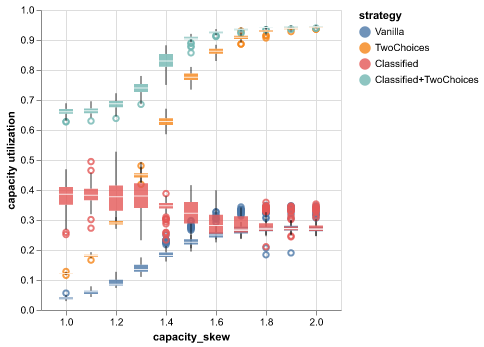

In [2]:
df = pl.read_csv(
    "ingest/*-sys.csv", schema_overrides={"capacity_skew": pl.Float32}
).with_columns(
    (pl.col("utilized_capacity") / pl.col("total_capacity")).alias(
        "capacity utilization"
    ),
    (pl.col("total_capacity") / pl.col("num_node")).alias("average node capacity"),
)
util = (
    alt.Chart(df)
    .mark_boxplot(opacity=0.8)
    .encode(
        alt.X("capacity_skew").scale(zero=False),
        alt.Y("capacity utilization"),
        alt.Color("strategy").sort(
            ["Vanilla", "Classified", "TwoChoices", "Classified+TwoChoices"]
        ),
    )
)
util

In [10]:
util.save("graphs/util.pdf")

In [ ]:
(
    alt.Chart(df)
    .mark_boxplot()
    .encode(
        alt.X("strategy").axis(None),
        alt.Y("capacity utilization"),
        alt.Color("strategy").sort(
            ["Vanilla", "Classified", "TwoChoices", "Classified+TwoChoices"]
        ),
        alt.Column("capacity_skew").header(title=None, labelOrient="bottom").spacing(0),
    )
    .configure_axis(grid=False)
    .configure_view(stroke=None)
    .properties(width=20)
)

In [ ]:
df = pl.read_csv(
    "ingest/*-bin.csv", schema_overrides={"capacity_skew": pl.Float32}
).with_columns(
    (pl.col("bin_capacity") / pl.col("num_bin_node")).alias("bin average capacity"),
    (pl.col("bin_used_capacity") / pl.col("bin_capacity")).alias("bin utilization"),
    (pl.col("bin_hit_count") / pl.col("num_bin_node")).alias("bin average hit"),
    (pl.col("bin_hit_count") / pl.col("bin_capacity")).alias("bin capacity frequency"),
)
df

In [ ]:
f = pl.col("capacity_skew") == 1.0
f |= pl.col("capacity_skew") == 1.3
f |= pl.col("capacity_skew") == 2.0
capacity_discoverability = alt.Chart(df.filter(f)).encode(
    alt.X("bin_index"),
    alt.Color("strategy"),
    alt.XOffset("strategy"),
)


def capacity_discoverability(col, y_scale="linear"):
    return (
        capacity_discoverability.encode(alt.Y(col).scale(type=y_scale)).mark_errorbar(
            extent="stdev", ticks=True
        )
        + capacity_discoverability.encode(alt.Y(col, aggregate="mean")).mark_line(point=True)
    ).facet(row="capacity_skew")


capacity_discoverability("bin utilization") | capacity_discoverability("bin capacity frequency") | capacity_discoverability(
    "bin average hit", "log"
)

## Frequency

### Storage frequency balance across classes

In [15]:
df = (
    pl.read_csv("freq/*-class.csv")
    .with_columns(
        (
            pl.col("class_hit_count") / pl.col("num_find") / pl.col("num_class_node")
        ).alias("class node frequency"),
    )
    .with_columns(
        (pl.col("class node frequency") / pl.col("class_capacity")).alias(
            "class storage frequency"
        ),
    )
)
df

strategy,num_node,num_find,find_size,num_class,skew,class,num_class_node,class_capacity,class_hit_count,class node frequency,class storage frequency
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
"""Vanilla""",10000,1000000,3,8,1,0,163804,163804,49181137,0.0003,1.8329e-9
"""Vanilla""",10000,1000000,3,8,1,1,135424,325018,40557524,0.000299,9.2144e-10
"""Vanilla""",10000,1000000,3,8,1,2,124762,657266,37490232,0.0003,4.5719e-10
"""Vanilla""",10000,1000000,3,8,1,3,118135,1302985,35409148,0.0003,2.3004e-10
"""Vanilla""",10000,1000000,3,8,1,4,116188,2622068,34845516,0.0003,1.1438e-10
…,…,…,…,…,…,…,…,…,…,…,…
"""Classified""",10000,1000000,3,8,1,3,118465,1306774,9731118,0.000082,6.2860e-11
"""Classified""",10000,1000000,3,8,1,4,115407,2604535,18924662,0.000164,6.2960e-11
"""Classified""",10000,1000000,3,8,1,5,114265,5222635,37451145,0.000328,6.2757e-11


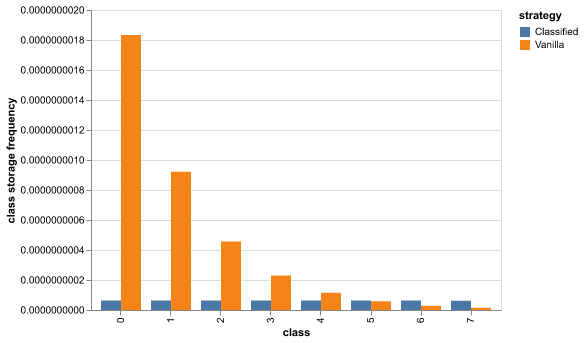

In [16]:
class_freq = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        alt.X("class:N"),
        alt.Y("class storage frequency"),
        alt.Color("strategy"),
        alt.XOffset("strategy"),
    )
)
class_freq

In [17]:
class_freq.save("graphs/class-capacity-freq.pdf")

### Node frequency CDF

In [ ]:
df = pl.read_csv("freq/*-node.csv")
df
chart = (
    alt.Chart(df)
    .mark_line(clip=True)
    .encode(
        alt.X("freq").scale(domainMax=0.0006), alt.Y("quantile"), alt.Color("strategy")
    )
)
chart

### Capacity frequency CDF

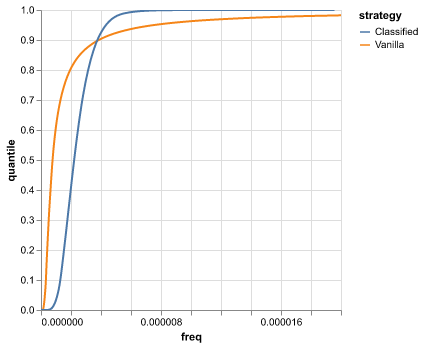

In [18]:
df = pl.read_csv("freq/*-capacity.csv")
df
cdf = (
    alt.Chart(df)
    .mark_line(clip=True)
    .encode(
        alt.X("freq").scale(domainMax=0.00002),
        alt.Y("quantile"),
        alt.Color("strategy"),
    )
)
cdf

In [19]:
cdf.save("graphs/capacity-freq-cdf.pdf")

In [35]:
(class_freq | cdf).save("graphs/capacity-freq.pdf")

## Inject with rejection

### Number of attempts vs. utilized capacity

In [20]:
df = pl.read_csv("ingest-reject/*.csv").with_columns(
    (pl.col("num_stored") * pl.col("num_copy") / pl.col("supply")).alias("utilization"),
    (1 - pl.col("store_rate")).alias("rejection rate"),
)
df

num_node,node_min_capacity,capacity_multiplier,capacity_skew,num_copy,strategy,supply,num_attempt,store_rate,num_stored,utilization,rejection rate
i64,i64,i64,i64,i64,str,i64,i64,f64,i64,f64,f64
12000,1024,128,1,3,"""Vanilla""",136508433,100000,1.0,100000,0.002198,0.0
12000,1024,128,1,3,"""Vanilla""",136508433,200000,1.0,200000,0.004395,0.0
12000,1024,128,1,3,"""Vanilla""",136508433,300000,1.0,300000,0.006593,0.0
12000,1024,128,1,3,"""Vanilla""",136508433,400000,1.0,400000,0.008791,0.0
12000,1024,128,1,3,"""Vanilla""",136508433,500000,1.0,500000,0.010988,0.0
…,…,…,…,…,…,…,…,…,…,…,…
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9600000,1.0,9600000,0.204703,0.0
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9700000,1.0,9700000,0.206835,0.0
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9800000,1.0,9800000,0.208967,0.0


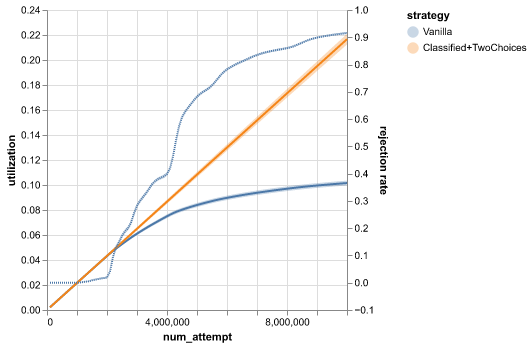

In [21]:
base = alt.Chart(df).encode(
    alt.X("num_attempt"),
    alt.Color("strategy").sort(["Classified+TwoChoices", "Vanilla"]),
)
num_stored = (
    base.encode(alt.Y("utilization")).mark_errorband(extent="stdev")
    + base.encode(alt.Y("utilization", aggregate="mean")).mark_line()
)
base = alt.Chart(df.filter(pl.col("strategy") == "Vanilla")).encode(
    alt.X("num_attempt")
)
rejection_rate = base.encode(
    alt.Y("rejection rate", aggregate="mean").scale(domainMax=1.0)
).mark_line(strokeDash=[1, 1]) + base.encode(alt.Y("rejection rate")).mark_errorband(
    extent="stdev"
)
reject = (
    alt.layer(num_stored, rejection_rate)
    .resolve_axis(y="independent")
    .resolve_scale(y="independent")
)
reject

In [22]:
df = (
    pl.read_csv("ingest-evict/*.csv")
    .with_columns(
        (pl.col("num_stored") * pl.col("num_copy") / pl.col("supply")).alias(
            "utilization"
        ),
        (pl.col("num_loss") / pl.col("num_stored")).alias("loss rate"),
        (pl.col("num_evict") / pl.col("supply")).alias("evicted utilization"),
    )
    .with_columns(
        pl.col("utilization").round(2).alias("binned utilization"),
        (pl.col("utilization") - pl.col("evicted utilization")).alias(
            "actual utilization"
        ),
    )
)
df

num_node,node_min_capacity,capacity_multiplier,capacity_skew,num_copy,strategy,supply,num_stored,num_evict,num_loss,utilization,loss rate,evicted utilization,binned utilization,actual utilization
i64,i64,i64,i64,i64,str,i64,i64,i64,i64,f64,f64,f64,f64,f64
12000,1024,128,1,3,"""Vanilla""",139308976,100000,0,0,0.002153,0.0,0.0,0.0,0.002153
12000,1024,128,1,3,"""Vanilla""",139308976,200000,0,0,0.004307,0.0,0.0,0.0,0.004307
12000,1024,128,1,3,"""Vanilla""",139308976,300000,0,0,0.00646,0.0,0.0,0.01,0.00646
12000,1024,128,1,3,"""Vanilla""",139308976,400000,0,0,0.008614,0.0,0.0,0.01,0.008614
12000,1024,128,1,3,"""Vanilla""",139308976,500000,0,0,0.010767,0.0,0.0,0.01,0.010767
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12000,1024,128,1,3,"""Vanilla""",134880212,9600000,9588313,614926,0.213523,0.064055,0.071088,0.21,0.142435
12000,1024,128,1,3,"""Vanilla""",134880212,9700000,9779221,634392,0.215747,0.065401,0.072503,0.22,0.143244
12000,1024,128,1,3,"""Vanilla""",134880212,9800000,9970672,653963,0.217971,0.066731,0.073922,0.22,0.144049


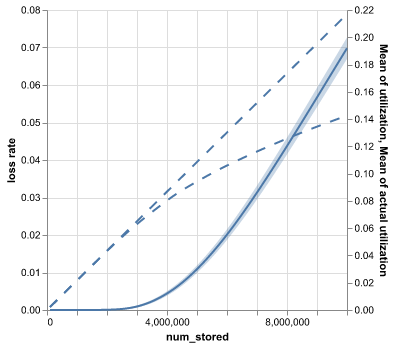

In [23]:
base = alt.Chart(df).encode(alt.X("num_stored"))
loss = (
    base.encode(alt.Y("loss rate").scale(domainMin=0.0)).mark_errorband(extent="stdev")
    + base.encode(alt.Y("loss rate", aggregate="mean")).mark_line()
)
base = alt.Chart(df).encode(alt.X("num_stored"))
util = base.encode(alt.Y("utilization", aggregate="mean")).mark_line(
    strokeDash=[10, 10],
)
actual_util = base.encode(alt.Y("actual utilization", aggregate="mean")).mark_line(
    strokeDash=[10, 10],
)
evict = alt.layer(loss, (util + actual_util)).resolve_axis(y="independent").resolve_scale(
    y="independent"
)
evict

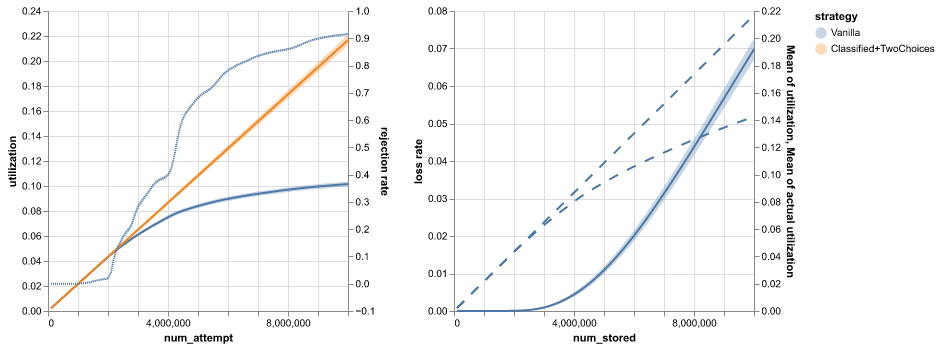

In [24]:
reject | evict

In [26]:
(reject | evict).save("graphs/overwhelm.pdf")

## Available capacity heatmap

In [27]:
df = (
    pl.read_csv("ingest-capacity/*-evict.csv")
    .group_by(pl.col("strategy"), pl.col("capacity"), pl.col("available_capacity"))
    .agg(pl.col("num_bin_node").sum())
)
df

strategy,capacity,available_capacity,num_bin_node
str,f64,f64,i64
"""Classified+TwoChoices""",13.92,12.86,6
"""Vanilla""",10.26,9.64,11
"""Classified+TwoChoices""",11.11,10.75,37
"""Classified+TwoChoices""",16.16,14.55,6
"""Classified+TwoChoices""",14.13,13.33,11
…,…,…,…
"""Classified+TwoChoices""",16.68,13.36,2
"""Classified+TwoChoices""",13.67,11.77,1
"""Classified+TwoChoices""",12.97,11.84,3


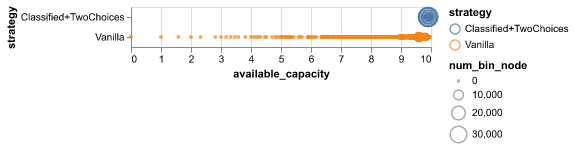

In [28]:
ac_freq = df.filter(pl.col("capacity") == 10).group_by("strategy", "available_capacity").agg(
    pl.col("num_bin_node").sum()
)
ac_distr = alt.Chart(ac_freq).encode(
    alt.X("available_capacity"), alt.Color("strategy"), alt.Y("strategy"), alt.Size("num_bin_node")
).mark_point()
ac_distr

In [32]:
ac_distr.save("graphs/ac-distr.pdf")

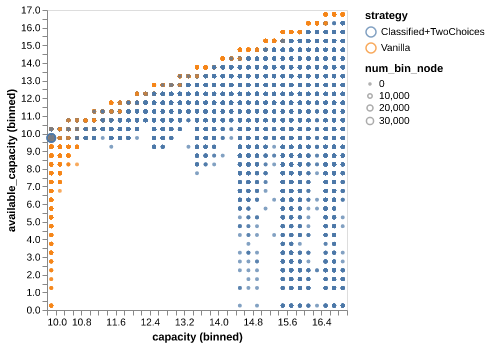

In [155]:
alt.Chart(df).encode(
    alt.X("capacity").bin(maxbins=40).scale(zero=False),
    alt.Y("available_capacity").bin(maxbins=40).scale(zero=False),
    alt.Color("strategy"),
    alt.Size("num_bin_node")
).mark_point()

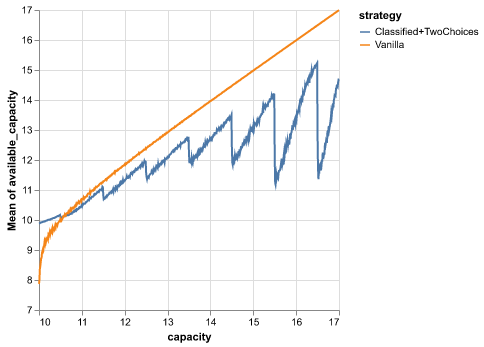

In [5]:
ac_balance = alt.Chart(df).encode(
    alt.X("capacity").scale(zero=False),
    alt.Y("mean(available_capacity)").scale(zero=False),
    alt.Color("strategy"),
).mark_line()
ac_balance

In [31]:
ac_balance.save("graphs/nc-ac.pdf")